In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Numerical Estimation of Orthogonal Polynomials

Walter Gautchi (a CS professor at Purdue) had created a Fortran package (ORTHPOL) that constructs orthogonal polynomials given an arbitrary weight function.  The package is available at [here](https://www.cs.purdue.edu/homes/wxg/selected_works/section_11/141.pdf).
I have recoded the package in Python and added some additional features.

The package is based on two important theorems.
In what follows, there is a random variable $\Xi$ and we are working within the Hilbert space $L^2(\Xi)$ with the usual inner product.
The polynomials we construct are named $\pi_k(\xi)$.

**Theorem 1:**  *There is a unique set of (monic) orthogonal polynomials:*

$$
\pi_k(\xi) = \xi^k + \text{lower order terms},
$$

*satisfying:*

$$
\langle \pi_k, \pi_l \rangle = 0 \quad \text{if} \quad k \neq l.
$$

The other important theorem is the *three-term recurrence relation*.
This relation enables us to construct and evaluate the polynomials efficiently.

**Theorem 2:**  *The polynomials satisfy the three-term recurrence relation:*

$$
\pi_{k+1}(\xi) = (\xi - \alpha_k) \pi_k(\xi) - \beta_k \pi_{k-1}(\xi).
$$

*where:*

$$
\alpha_k = \frac{\langle \xi \pi_k, \pi_k \rangle}{\langle \pi_k, \pi_k \rangle}
$$

*and:*

$$
\beta_k = \frac{\langle \pi_k, \pi_k \rangle}{\langle \pi_{k-1}, \pi_{k-1} \rangle}
$$

*and:*

$$
\pi_{-1}(\xi) = 0 \quad \text{and} \quad \pi_0(\xi) = 1.
$$

Orthonormal polynomials constructed in this way are called **polynomial chaos**.
The name has nothing to do with chaos theory of dynamical systems.

## Orthojax

You will have to install the package [orthojax](https://pypi.org/project/orthojax/):

In [2]:
!pip install orthojax --upgrade

DEPRECATION: graphql-ws 0.3.0 has a non-standard dependency specifier graphql-core>=2.0<3. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of graphql-ws or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## Example: Uniform random variable on $[0, 2]$

Let $\Xi \sim U([0,2])$. The PDF is:

$$
p(\xi) = \frac{1}{2} \quad \text{for} \quad \xi \in [0,2].
$$

Here is how we can construct the polynomials:

In [20]:
import orthojax as ojax

degree = 10
pdf = lambda xi: 0.5
poly = ojax.make_orthogonal_polynomial(degree, left=0.0, right=2.0, wf=pdf)

Here is how the object looks like:

In [21]:
poly

OrthogonalPolynomial(
  alpha=f32[11],
  beta=f32[11],
  gamma=f32[11],
  quad=QuadratureRule(x=f32[100], w=f32[100])
)

Here are the recursion coefficients:

In [22]:
poly.alpha, poly.beta, poly.gamma

(Array([1.        , 1.0000025 , 0.99999017, 1.0000262 , 0.999944  ,
        1.0001017 , 0.9998344 , 1.0002512 , 0.9996395 , 1.0004972 ,
        0.9993389 ], dtype=float32),
 Array([1.        , 0.5773435 , 0.51641864, 0.5070478 , 0.50403017,
        0.50240046, 0.5019109 , 0.5010617 , 0.5012555 , 0.50043714,
        0.50102293], dtype=float32),
 Array([1.        , 0.5773435 , 0.51641864, 0.5070478 , 0.50403017,
        0.50240046, 0.5019109 , 0.5010617 , 0.5012555 , 0.50043714,
        0.50102293], dtype=float32))

Let's plot the polynomials:

In [23]:
import numpy as np

xis = np.linspace(0.0, 2.0, 200)
phi = poly(xis)
phi.shape

(200, 11)

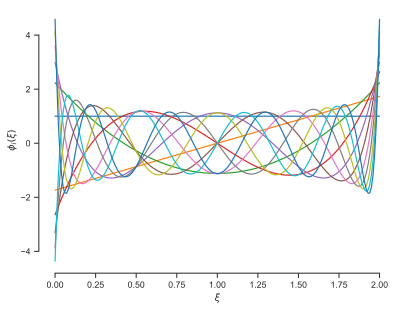

In [24]:
fig, ax = plt.subplots()
ax.plot(xis, phi)
ax.set(xlabel=r"$\xi$", ylabel=r"$\phi_i(\xi)$")
sns.despine(trim=True)

Are they really orthonormal? Let's check using a quadrature rule to calculate the required inner products.
Recall that a quadrature rule is a tuple of points and weights:

$$
\left\{ \xi_i, w_i \right\}_{i=1}^n
$$

such that:

$$
\int_{\Xi} f(\xi) p(\xi) d\xi \approx \sum_{i=1}^n w_i f(\xi_i).
$$

You learn about them in ME 581. Typical quadrature rules are the trapezoidal rule, Simpson's rule, and Gauss quadrature. Here we are using the Fejer quadrature rule. The rule is exact for polynomials of a certain degree.

In particular, we can approximate the norm of a basis function by:

$$
\|\phi_i\|^2 = \langle \phi_i, \phi_i \rangle \approx \sum_{j=1}^n w_j \phi_i(\xi_j)^2.
$$

In [27]:
x, w = poly.quad
phis = poly(x)

norms = np.einsum("i,ij->j", w, phis ** 2)

for i in range(degree + 1):
    print(f"‖φ{i}‖ \t= {norms[i]:.2f}")

‖φ0‖ 	= 1.00
‖φ1‖ 	= 1.00
‖φ2‖ 	= 1.00
‖φ3‖ 	= 1.00
‖φ4‖ 	= 1.00
‖φ5‖ 	= 1.00
‖φ6‖ 	= 1.00
‖φ7‖ 	= 1.00
‖φ8‖ 	= 1.00
‖φ9‖ 	= 1.00
‖φ10‖ 	= 1.00


Let's check orthogonality.
We approximate the inner product by:

$$
\langle \phi_i, \phi_j \rangle \approx \sum_{k=1}^n w_k \phi_i(\xi_k) \phi_j(\xi_k).
$$

In [28]:
for i in range(poly.num_terms):
    for j in range(i + 1, poly.num_terms):
        inner_phi_i_phi_j = np.sum(w * phis[:, i] * phis[:, j])
        print(f"<φ{i},φ{j}> \t= {inner_phi_i_phi_j:.2f}")

<φ0,φ1> 	= 0.00
<φ0,φ2> 	= 0.00
<φ0,φ3> 	= -0.00
<φ0,φ4> 	= -0.00
<φ0,φ5> 	= 0.00
<φ0,φ6> 	= 0.00
<φ0,φ7> 	= -0.00
<φ0,φ8> 	= -0.00
<φ0,φ9> 	= 0.00
<φ0,φ10> 	= 0.00
<φ1,φ2> 	= -0.00
<φ1,φ3> 	= -0.00
<φ1,φ4> 	= 0.00
<φ1,φ5> 	= 0.00
<φ1,φ6> 	= -0.00
<φ1,φ7> 	= -0.00
<φ1,φ8> 	= 0.00
<φ1,φ9> 	= 0.00
<φ1,φ10> 	= -0.00
<φ2,φ3> 	= 0.00
<φ2,φ4> 	= 0.00
<φ2,φ5> 	= -0.00
<φ2,φ6> 	= -0.00
<φ2,φ7> 	= 0.00
<φ2,φ8> 	= 0.00
<φ2,φ9> 	= -0.00
<φ2,φ10> 	= -0.00
<φ3,φ4> 	= -0.00
<φ3,φ5> 	= -0.00
<φ3,φ6> 	= 0.00
<φ3,φ7> 	= 0.00
<φ3,φ8> 	= -0.00
<φ3,φ9> 	= -0.00
<φ3,φ10> 	= 0.00
<φ4,φ5> 	= 0.00
<φ4,φ6> 	= 0.00
<φ4,φ7> 	= -0.00
<φ4,φ8> 	= -0.00
<φ4,φ9> 	= 0.00
<φ4,φ10> 	= 0.00
<φ5,φ6> 	= -0.00
<φ5,φ7> 	= -0.00
<φ5,φ8> 	= 0.00
<φ5,φ9> 	= 0.00
<φ5,φ10> 	= -0.00
<φ6,φ7> 	= 0.00
<φ6,φ8> 	= 0.00
<φ6,φ9> 	= -0.00
<φ6,φ10> 	= -0.00
<φ7,φ8> 	= -0.00
<φ7,φ9> 	= -0.00
<φ7,φ10> 	= 0.00
<φ8,φ9> 	= 0.00
<φ8,φ10> 	= 0.00
<φ9,φ10> 	= -0.00


This is pretty close to zero.

## Example: Hermite Polynomials

Let $\Xi \sim N(0,1)$.
We can construct the polynomials like this:

In [10]:
import math

degree = 10
pdf = lambda xi: np.exp(-xi ** 2 / 2) / np.sqrt(2.0 * np.pi)
poly = ojax.make_orthogonal_polynomial(degree, left=-math.inf, right=math.inf, wf=pdf)

Let's just plot them:

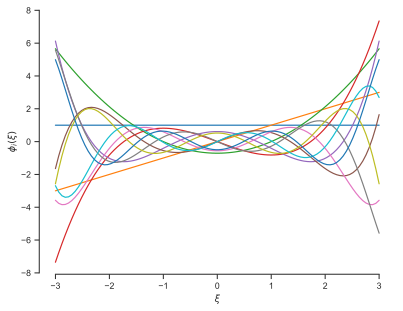

In [11]:
xis = np.linspace(-3.0, 3.0, 100)
phi = poly(xis)

fig, ax = plt.subplots()
ax.plot(xis, phi)
ax.set(xlabel=r"$\xi$", ylabel=r"$\phi_i(\xi)$")
sns.despine(trim=True)

## Example: Mixture of Gaussians

Let's do a non-trivial example where we construct orthogonal polynomials for a Gaussian mixture.
The random variable is:

$$
\Xi \sim 0.5 N(-1, 0.5^2) + 0.5 N(1, 0.5^2).
$$

The PDF is:

$$
p(\xi) = 0.5 \frac{1}{\sqrt{2 \pi} 0.5} \exp \left( - \frac{(\xi + 1)^2}{2 (0.5)^2} \right) + 0.5 \frac{1}{\sqrt{2 \pi} 0.5} \exp \left( - \frac{(\xi - 1)^2}{2 (0.5)^2} \right).
$$

Here we go:

In [12]:
degree = 10
pdf = lambda xi: 0.5 * np.exp(-(xi + 1.0) ** 2 / 2 / 0.5 ** 2) / np.sqrt(2.0 * np.pi * 0.5 ** 2) \
    + 0.5 * np.exp(-(xi - 1.0) ** 2 / 2 / 0.5 ** 2) / np.sqrt(2.0 * np.pi * 0.5 ** 2)
poly = ojax.make_orthogonal_polynomial(degree, left=-math.inf, right=math.inf, wf=pdf)

And here is how the look like:

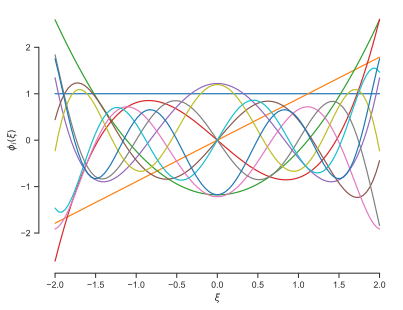

In [13]:
xis = np.linspace(-2.0, 2.0, 100)
phi = poly(xis)

fig, ax = plt.subplots()
ax.plot(xis, phi)
ax.set(xlabel=r"$\xi$", ylabel=r"$\phi_i(\xi)$")
sns.despine(trim=True)

## Example: Projecting a function onto the orthogonal basis

Let's say we have a function $f(\xi)$ and we want to project it onto the orthogonal basis.
The projection is:

$$
f(\xi) = \sum_{k=0}^n \langle f, \pi_k \rangle \pi_k(\xi).
$$

So, just need to be able to do the inner products.
Let's demonstrate with the Legendre polynomials.

In [14]:
poly = ojax.make_legendre_polynomial(degree).normalize()
x, w = poly.quad

# Just a function to project
f = lambda x: np.sin(10 * x) / (10 * x)

# The projection
proj = np.einsum("i,ij,i->j", f(x), poly(x), w)
proj

array([ 1.6583475e-01, -4.9767550e-09, -1.5908138e-01, -3.1719683e-06,
        1.8076573e-01,  2.2900640e-05, -2.1764600e-01, -8.9398352e-05,
        1.2994759e-01,  2.0104554e-04, -4.2646304e-02], dtype=float32)

Let's visualize the projection:

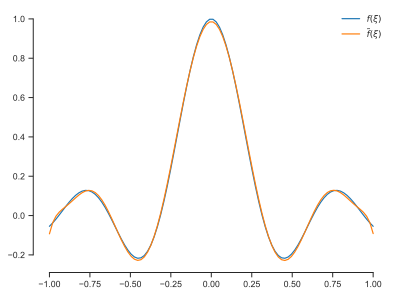

In [15]:
proj_f = lambda xi: np.einsum("k,ik->i", proj, poly(xi))

xis = np.linspace(-1.0, 1.0, 100)
fig, ax = plt.subplots()
ax.plot(xis, f(xis), label=r"$f(\xi)$")
ax.plot(xis, proj_f(xis), label=r"$\tilde{f}(\xi)$")
ax.legend(loc="best", frameon=False)
sns.despine(trim=True)

Okay, pretty good.

## Example: Calculating statistics of a random variable 

Let's use the polynomial chaos expansions to calculate statistics of a random variable.

Take:

$$
\Xi \sim N(0, 1),
$$

and then:

$$
Z = f(\Xi) = \sin(2 \Xi) / (2\Xi).
$$

We want the mean and variance of $Z$.

First, we will project $f$ on the polynomial basis:

$$
f(\xi) = \sum_{k=0}^n \langle f, \pi_k \rangle \pi_k(\xi) = \sum_{k=0}^n f_k \pi_k(\xi).
$$

The mean is just the first coefficient:

$$
\mathbb{E}[Z] = \mathbb{E}[f(\Xi)] = \langle f, \pi_0 \rangle = f_0.
$$

Recall that $\pi_0 = 1$ (the constant polynomial).

The variance is:

$$
\text{Var}[Z] = \mathbb{E}[Z^2] - \mathbb{E}[Z]^2 = \sum_{k=1}^n f_k^2 - f_0^2.
$$

In [16]:
degree = 11
poly = ojax.make_hermite_polynomial(degree)
x, w = poly.quad
f = lambda x: np.sin(2 * x) / (2 * x)
proj = np.einsum("i,ij,i->j", f(x), poly(x), w)

mean = proj[0]
print(f"mean: {mean}")

var = np.sum(proj[1:] ** 2)
print(f"variance: {var}")

mean: 0.5981440544128418
variance: 0.14386773109436035


Let's compare with the Monte Carlo estimates:

In [17]:
xis = np.random.randn(10_000)
samples = f(xis)
mc_mean = np.mean(samples)
mc_var = np.var(samples)
print(f"MC mean: {mc_mean}")
print(f"MC variance: {mc_var}")

MC mean: 0.5966954762780894
MC variance: 0.1448722874750317
